# colab and imports

In [44]:
# generic & ml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import numpyro

import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS
from numpyro.handlers import seed, trace
import pprint as pp

import scanpy as sc

In [2]:
import anndata
from collections import namedtuple

In [3]:
# from utils import *
from noise_model import Noise_Model
from sklearn.decomposition import PCA

# from torch_losses import *

In [4]:
default_device = jax.devices()[0]
print(default_device)

TFRT_CPU_0


I0000 00:00:1702554744.240248       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


# Loading data

In [5]:
adatas = {"Tomaz": sc.read_h5ad("data/130723_data_hepatocytes.h5ad")}
data = anndata.concat(adatas, label="dataset", join="inner")
sample_names = data.obs["orig.ident"]
sample_list = np.unique(sample_names)

# extact on single sample
# single_sample = "scRNA_Seq_Tomaz_220531-03-M-ZT22-H-lib_1-129S"
# data_single = data[sample_names == single_sample, :]
# data_single


# removing the bad replicate
remove = "scRNA_Seq_Tomaz_220531-01-M-ZT22-H-lib_1-129S"
remove_mask = np.invert(sample_names == remove)
data = data[remove_mask, :]
# update the list after removing the bad one
sample_list = sample_list[
    np.logical_not(sample_list == "scRNA_Seq_Tomaz_220531-01-M-ZT22-H-lib_1-129S")
]

In [6]:
# filter mitochoncdrial genes

genes_mito = [s.startswith("mt-") for s in data.var.index]
genes_Mup = [s.startswith("Mup") for s in data.var.index]
genes_keep = np.logical_not(np.logical_or(genes_mito, genes_Mup))
cells_keep = data.obs["percent.mt"] > 3

# should we do this sample by sample?
# data = data[cells_mito,:]

data = data[cells_keep, genes_keep]
data.shape

(20093, 18742)

In [7]:
# #make design matrix: number of cells x number of samples
sample_names = data.obs["orig.ident"]
sample_names_uniq = np.unique(data.obs["orig.ident"])
sample_annot = [
    [i] + s.split("_")[3].split("-")[0:4] for i, s in enumerate(sample_names_uniq)
]
sample_annot = np.array(sample_annot)

In [8]:
sample_annot[:, 3]
mask_f = data.obs["Sex"].values == "female"
mask_T = data.obs["ZT"].values == "10"
mask_T

array([ True,  True,  True, ...,  True,  True,  True])

In [9]:
# design matrix is torch.tensor as it is used in pyro
sample_id = np.zeros(data.n_obs, dtype=np.int64)
for i, s in enumerate(sample_names_uniq):
    sample_id[sample_names == s] = i

data.obs["sample_id"] = sample_id

/var/folders/8w/hhwzbx0d6zg_2q5hrl31_yn00000gq/T/ipykernel_22505/249532750.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data.obs["sample_id"] = sample_id


In [10]:
def make_design_matrix(sample_id):
    design_matrix = np.hstack(
        [np.array(sample_id == i).astype(int).reshape(len(sample_id), 1)
        for i in np.unique(sample_id)]
    )
    return design_matrix


design_matrix = make_design_matrix(sample_id)

<Axes: >

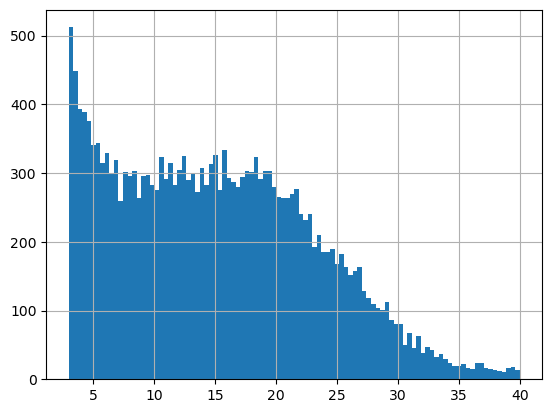

In [11]:
data.obs["percent.mt"].hist(bins=100)

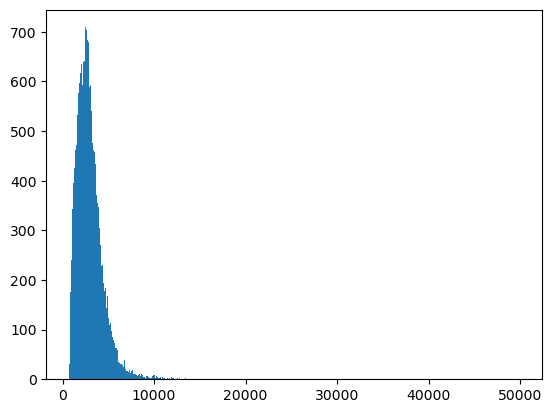

In [12]:
# normalize each sample
data.layers["n_cg"] = data.X.toarray()
data.layers["f_cg"] = data.layers["n_cg"].copy()
nc = np.zeros(data.n_obs)
for s in np.unique(sample_id):
    idx = sample_id == s
    tmp = data.layers["n_cg"][idx, :].sum(axis=1)
    nc[idx] = tmp
    data.layers["f_cg"][idx, :] = (
        data.layers["f_cg"][idx, :] / tmp[:, None]
    )  # normalization!
data.obs["n_c"] = nc
plt.hist(data.obs["n_c"], bins=500)
plt.show()

In [13]:
def gene_index(data, gene):
    return np.where(gene == data.var.index)[0][0]

Initalizing the zero-order Legendre coefficient to the mean

In [14]:
# from Hildebrandt 2021
central = [
    "Oat",
    "Cyp2e1",
    "Lect2",
    "Cyp2c37",
    "Gulo",
    "Cyp2a5",
    "Glul",
    "Aldh1a1",
    "Cyp1a2",
    "Slc22a1",
    "Slc1a2",
]
portal = ["Pck1", "Aldh1b1", "Ctsc", "Sds", "Hal", "Hsd17b13", "Cyp2f2"]


# new list based on our method
# portal=['Pigr', 'Plxna2', 'B4galt5', 'Pck1', 'Etnppl', 'Slc25a51', 'Arhgap24',
#        'Hsd17b13', 'Sds', 'Retsat', 'Uroc1', 'Apoc2', 'Cyp2a4', 'Cyp2f2',
#        'Hpx', 'Fgfr2', 'Slc7a2', 'Apoa4', 'Ftcd', 'Hal', 'Gls2', 'Serpina1d',
#        'Aspg', 'Gcnt2', 'Sfxn1', 'C9', 'Gldc']
# central=['Aox1', 'Cyp27a1', 'Glul', 'Esrrg', 'Fam107b', 'Cyp7b1', 'Cyp7a1',
#        'Pon1', 'Slco1b2', 'Cyp2a5', 'Oat', 'Cyp2e1', 'Tenm3', 'Msmo1',
#        'Cyp1a2', 'Aqp9', 'Sult3a1', 'Slc16a10', 'Tafa2', 'Igfbp1', 'Aldh3a2',
#        'Rnf43', 'Ahr', 'Slc25a21', 'Rdh11', 'Acot3', 'Lect2', 'Ube2e2', 'Erc2',
#        'Rnase4', 'Ang', 'Ang4', 'Gulo', 'Cyp2d9', 'Csad', 'Slc22a1', 'Rmdn2',
#        'Ablim3', 'Aldh1a1', 'Cyp2c38', 'Cyp2c69', 'Cyp2c37', 'Cyp2c54',
#        'Cyp2c50', 'Slk', 'Cyp3a41b', 'Cyp3a41a', 'Cyp3a44', 'Sult3a2']


# genes=central+portal
genes = central + portal
mask_por = [g in portal for g in genes]

# check that they are all there (use set intersections)
# check that they are all there (use set intersections)
assert len(central) == len(set(central) & set(data.var.index))
assert len(portal) == len(set(portal) & set(data.var.index))

data_pyro = data[:, genes]

array([ True,  True,  True, ..., False, False, False])

# Meta param initialization

[0.19770662 0.09393372 0.08224063 0.05981319 0.05398534]


(20093,)

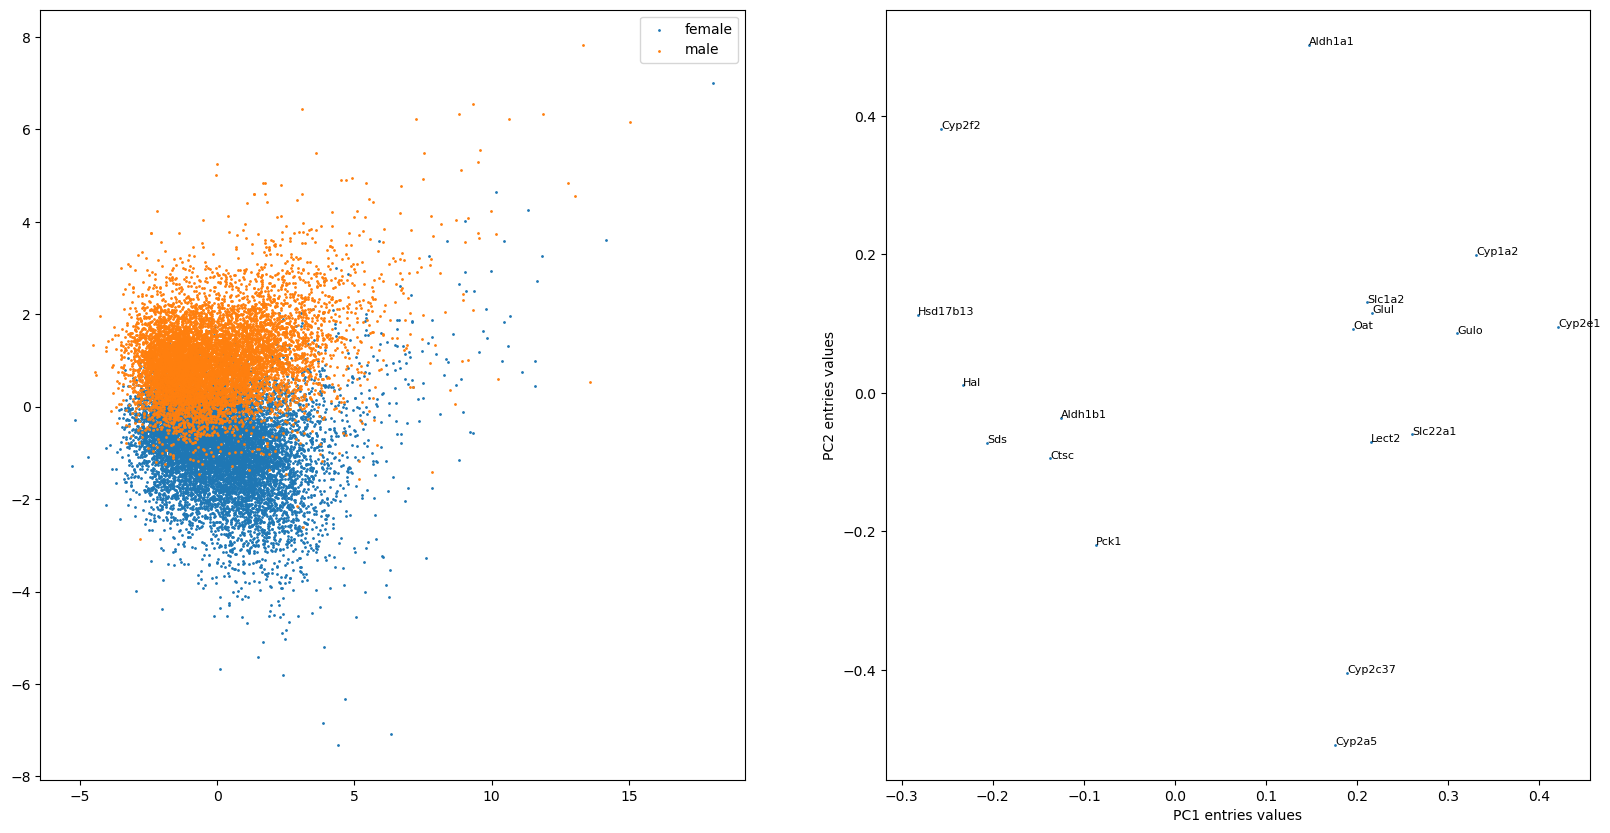

In [15]:
pca = PCA(n_components=5, whiten=False)
X_pca = data_pyro.layers["f_cg"]

# normalize yourself
X_pca = X_pca - X_pca.mean(axis=0)[None, :]
X_pca = X_pca / np.sqrt(X_pca.var(axis=0))[None, :]
PC = pca.fit_transform(X_pca)

# Print the explained variance ratio of the first two principal components
print(pca.explained_variance_ratio_)
# print(X_pca.data_pca)
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.scatter(PC[mask_f, 0], PC[mask_f, 1], label="female", s=1)
plt.scatter(
    PC[np.logical_not(mask_f), 0], PC[np.logical_not(mask_f), 1], label="male", s=1
)
plt.legend()
# plt.scatter(PC[:,0], PC[:,1], s=1,  c=mask_f, cmap='plasma')
# first two eigenvectors
x = pca.components_[0, :]
y = pca.components_[1, :]
plt.subplot(122)
plt.scatter(x, y, s=1)
ix = np.abs(x) > np.percentile(np.abs(x), 0)
iy = np.abs(y) > np.percentile(np.abs(y), 0)
ii = np.logical_or(ix, iy)
# print(np.sum(ii))
for i, txt in enumerate(data_pyro.var.index[ii]):
    plt.annotate(txt, (x[ii][i], y[ii][i]), fontsize=8)
plt.xlabel("PC1 entries values")
plt.ylabel("PC2 entries values")

# define initial x's
x_unif = PC[:, 0]
x_unif = x_unif - x_unif.mean()
x_unif = x_unif / np.sqrt(x_unif.var())
x_unif.shape

##

## Paus's coefficients

In [16]:
# calculates a running mean in windows of size N
def run_mean(x, y, N):
    o = x.argsort()
    x = x[o]
    y = y[o]
    cumsum = np.cumsum(np.insert(x, 0, 0))
    xm = (cumsum[N:] - cumsum[:-N]) / N
    cumsum = np.cumsum(np.insert(y, 0, 0))
    ym = (cumsum[N:] - cumsum[:-N]) / N
    return (xm, ym)

In [17]:
# Pau's fits
# from noise_model import Noise_Model

noise = "NB"
# for fits
# D=np.stack((np.repeat(1, data.n_obs),x_unif, x_unif*x_unif), axis=1)
D = np.stack((np.repeat(1, data.n_obs), x_unif), axis=1)
# print(D.shape)
# D=np.repeat(1, data.n_obs)[:,None]
coef_pau = np.zeros((len(genes), D.shape[1]))
logl = np.zeros((data.n_obs, len(genes)))
n_fit = np.zeros((data.n_obs, len(genes)))
alpha = np.zeros(len(genes))

logN = np.log(data.obs["n_c"].values)
for gi, g in enumerate(genes):
    x = x_unif
    y = data[:, [g]].layers["f_cg"].toarray()

    # plt.figure(figsize=(10,4))
    # plt.subplot(121)
    # plt.title(g)
    # plt.scatter(x, y, s=1, alpha=0.5)

    # Fit
    yy = data[:, [g]].layers["n_cg"].toarray().squeeze()
    model_n = Noise_Model(yy, D, logN, noise)

    iterations = 50
    mf = model_n.fit(iterations)
    if noise == "Poisson":
        coef_pau[gi, :] = mf
    else:
        coef_pau[gi, :] = mf[:-1]
        alpha[gi] = mf[-1]
    n_fit[:, gi] = np.exp(np.matmul(D, coef_pau[gi, :]))
    # tmp=np.stack((n_fit[:,gi]*data.obs['n_c'], np.repeat(alpha[gi], data.n_obs)), axis=1)
    tmp = np.stack((n_fit[:, gi] * data.obs["n_c"], np.repeat(1.0, data.n_obs)), axis=1)
    logl[:, gi] = model_n.loglikelihood(tmp)

    # x=x_unif
    # y=data[:,[g]].layers['f_cg'].toarray()
    # run=run_mean(x,y,100)

    # plt.subplot(122)
    # plt.scatter(run[0], run[1], s=1, alpha=0.5)
    # plt.scatter(x, n_fit[:,gi], s=1, alpha=1)
    # plt.title(logl[:,gi].sum(0))
    # # plt.yscale('log')
    # plt.show()

In [18]:
a0_pau = coef_pau[:, 0]
a1_pau = coef_pau[:, 1]

# Model

In [170]:
# subslect data from sample 0 and 1
data_01 = data[sample_id < 2, :]



(5680, 18742)

In [164]:
DATA = data_pyro[:, :].layers["n_cg"]


NC = DATA.shape[0]
NG = DATA.shape[1]
NS = design_matrix.shape[1]


# complete random
# X=torch.randn(NC,dtype=float)
# A1=torch.randn(NG)
# A0=torch.randn(NG)
# A0=A0.repeat(NS,1)

# PCA position, random a
# X=tt(x_unif)
# A1=torch.randn(NG)
# A0=torch.randn(NG)
# A0=A0.repeat(NS,1)

# opposite, x is free, the rest I use paus coeff
# X=torch.randn(NC,dtype=float)
# A1=tt(a1_pau,dtype=float)
# A0=tt(a0_pau,dtype=float)
# A0=A0.repeat(NS,1)

# INTIALISE BOTH!
X = x_unif.reshape(NC, 1)
A1 = a1_pau.reshape(1, NG)
A0 = a0_pau.reshape(1, NG)
# A0=[A0 for i in range(NS)]
# A0=np.stack(A0)
DISP = 0.3



# resizing the data

# mask for first 2 samples .... 
keep =  sample_id < 2
n_data = 2000
X = X[0:n_data]
log_c = np.log(np.array(data.obs["n_c"])[0:n_data]).reshape(n_data, 1)
# DATA = DATA[0:n_data, :]

In [57]:
mp = dict(
    a0_loc=A0,
    a1_loc=A1,
    x=X,
    log_n_UMI=log_c,
    disp=0.3,
    dm=design_matrix,
)
MyTuple = namedtuple("param", mp)
MP = MyTuple(**mp)


# mp_small = dict(
#     a0_loc=A0,
#     a1_loc=A1,
#     x=X[0:30],
#     log_n_UMI=np.log(np.array(data.obs["n_c"])[0:30]).reshape(30, 1),
#     disp=0.3,
#     dm=design_matrix,
# )
# MyTuple_small = namedtuple("param", mp_small)
# MP_small = MyTuple_small(**mp_small)

In [62]:
MP.x.shape

(2000, 1)

In [21]:
def model(mp, y=None):
    Nc = y.shape[0]
    Ng = y.shape[1]
    Ns = mp.dm.shape[1]

    sample_plate = numpyro.plate("samples", size=Ns, dim=-2)
    cell_plate = numpyro.plate("cells", size=Nc, dim=-2)
    gene_plate = numpyro.plate("genes", size=Ng, dim=-1)

    disp = numpyro.sample("disp", dist.Uniform(0.0, 1.0))

    with gene_plate:
        a1 = numpyro.sample("a1", dist.Uniform(-30.0, 30.0))

    with gene_plate, sample_plate:
        a0 = numpyro.sample("a0", dist.Uniform(-30, 30))

    with cell_plate:
        xx = numpyro.sample("x", dist.Uniform(-30.0, 30.0))

    log_mu = xx[:, None] * a1[None, :] + mp.log_n_UMI[:, None]
    log_mu += jnp.matmul(mp.dm[:, :], a0)

    cutoff = 50.0
    log_mu = cutoff * jnp.tanh(log_mu / cutoff)

    mu = jnp.exp(log_mu)
    ##Using the mean and dispersion parametrization
    conc = numpyro.deterministic("conc", 1 / disp)
    rate = numpyro.deterministic("rate", 1 / (disp * mu))
    print(DATA.shape, rate.shape)
    with cell_plate, gene_plate:
        numpyro.sample("obs_", dist.GammaPoisson(concentration=conc, rate=rate), obs=y)

In [66]:

def easy_model(mp, y=None):
    '''
    This model has a lower number of cells, coming all from the same sample,
    therefore there is no need to use the design matrix
    '''
    Nc = y.shape[0]
    Ng = y.shape[1]

    cell_plate = numpyro.plate("cells", size=Nc, dim=-2)
    gene_plate = numpyro.plate("genes", size=Ng, dim=-1)

    disp = numpyro.sample("disp", dist.Uniform(0.0, 1.0))

    with gene_plate:
        a1 = numpyro.sample("a1", dist.Normal(mp.a1_loc, 3.0))
        a0 = numpyro.sample("a0", dist.Normal(mp.a0_loc, 6.0))

    with cell_plate:
        xx = numpyro.sample("x", dist.Normal(mp.x, 3.0))

    # log_mu = xx * a1 + mp.log_n_UMI[:, None] + a0
    log_mu = xx * a1 + mp.log_n_UMI + a0

    cutoff = 50.0
    log_mu = cutoff * jnp.tanh(log_mu / cutoff)
    mu = jnp.exp(log_mu)

    ##Using the mean and dispersion parametrization
    # conc=numpyro.deterministic('conc', 1/disp)
    # rate=numpyro.deterministic('rate',1/(disp*mu))

    conc = 1 / disp
    rate = 1 / (disp * mu)

    with cell_plate:
        with gene_plate:
            numpyro.sample(
                "obs_", dist.GammaPoisson(concentration=conc, rate=rate), obs=y
            )

In [68]:
DATA.shape

(2000, 18)

In [71]:
rng_key = random.PRNGKey(0)
exec_trace = trace(seed(easy_model, rng_key)).get_trace(MP_small, data_small);
pp.pprint(exec_trace);


OrderedDict([('cells',
              {'args': (30, None),
               'cond_indep_stack': [],
               'fn': <function _subsample_fn at 0x1582723e0>,
               'kwargs': {'rng_key': None},
               'name': 'cells',
               'scale': 1.0,
               'type': 'plate',
               'value': Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)}),
             ('genes',
              {'args': (18, None),
               'cond_indep_stack': [],
               'fn': <function _subsample_fn at 0x1582723e0>,
               'kwargs': {'rng_key': None},
               'name': 'genes',
               'scale': 1.0,
               'type': 'plate',
               'value': Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int32)}),
             ('disp',
              {'args': (),
               'cond_indep_stack': [],
               'fn

In [70]:
# numpyro.render_model(easy_model, model_args=(MP_small, data_small), render_distributions=False)

In [72]:
init_params = {
    'a1': A1,
    'a0': A0,
    'x': X,
    'disp': 0.3
}   

In [73]:
DATA.shape

(2000, 18)

In [76]:
nuts_kernel = NUTS(easy_model)

# initalise samples
mcmc = MCMC(sampler=nuts_kernel, num_warmup=500, num_samples=1500, num_chains=1, progress_bar=True)
# init params flag does not work!
mcmc.run(rng_key, MP, y=DATA)# , init_params=(X, A0, A1, DISP))



sample: 100%|██████████| 2000/2000 [04:28<00:00,  7.46it/s, 31 steps of size 1.77e-01. acc. prob=0.88]   


# Analysis of MCMC sampling

In [77]:
samples = mcmc.get_samples()
means = dict()
errors = dict()
for key in samples.keys():
    means[key] = samples[key].mean(axis=0).squeeze()
    errors[key] = samples[key].std(axis=0).squeeze()

a0_pyro = means["a0"].flatten()
a1_pyro = means["a1"].flatten()
x_pyro = means["x"].flatten()
disp = means["disp"].flatten()

x_pyro = x_pyro.clone()

# x_mean=samples['x'][1000:,:].mean(axis=0).shape

Text(0, 0.5, 'x MCMC')

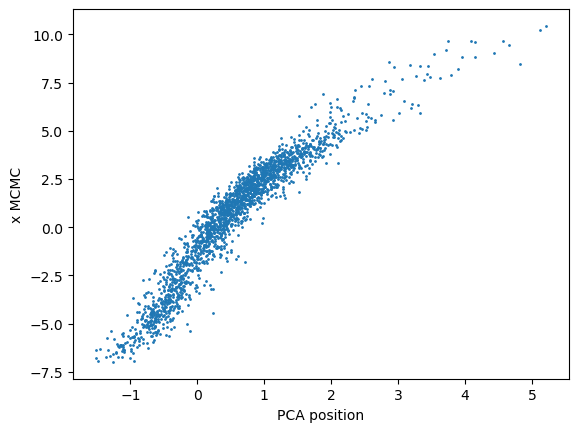

In [126]:
plt.scatter(x_unif[0:n_data], x_pyro, s=1)
# axis labels
plt.xlabel("PCA position")
plt.ylabel("x MCMC")

In [91]:
samples["a1"].shape

(1500, 1, 18)

['Oat', 'Cyp2e1', 'Lect2', 'Cyp2c37', 'Gulo', 'Cyp2a5', 'Glul', 'Aldh1a1', 'Cyp1a2', 'Slc22a1', 'Slc1a2', 'Pck1', 'Aldh1b1', 'Ctsc', 'Sds', 'Hal', 'Hsd17b13', 'Cyp2f2']


/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

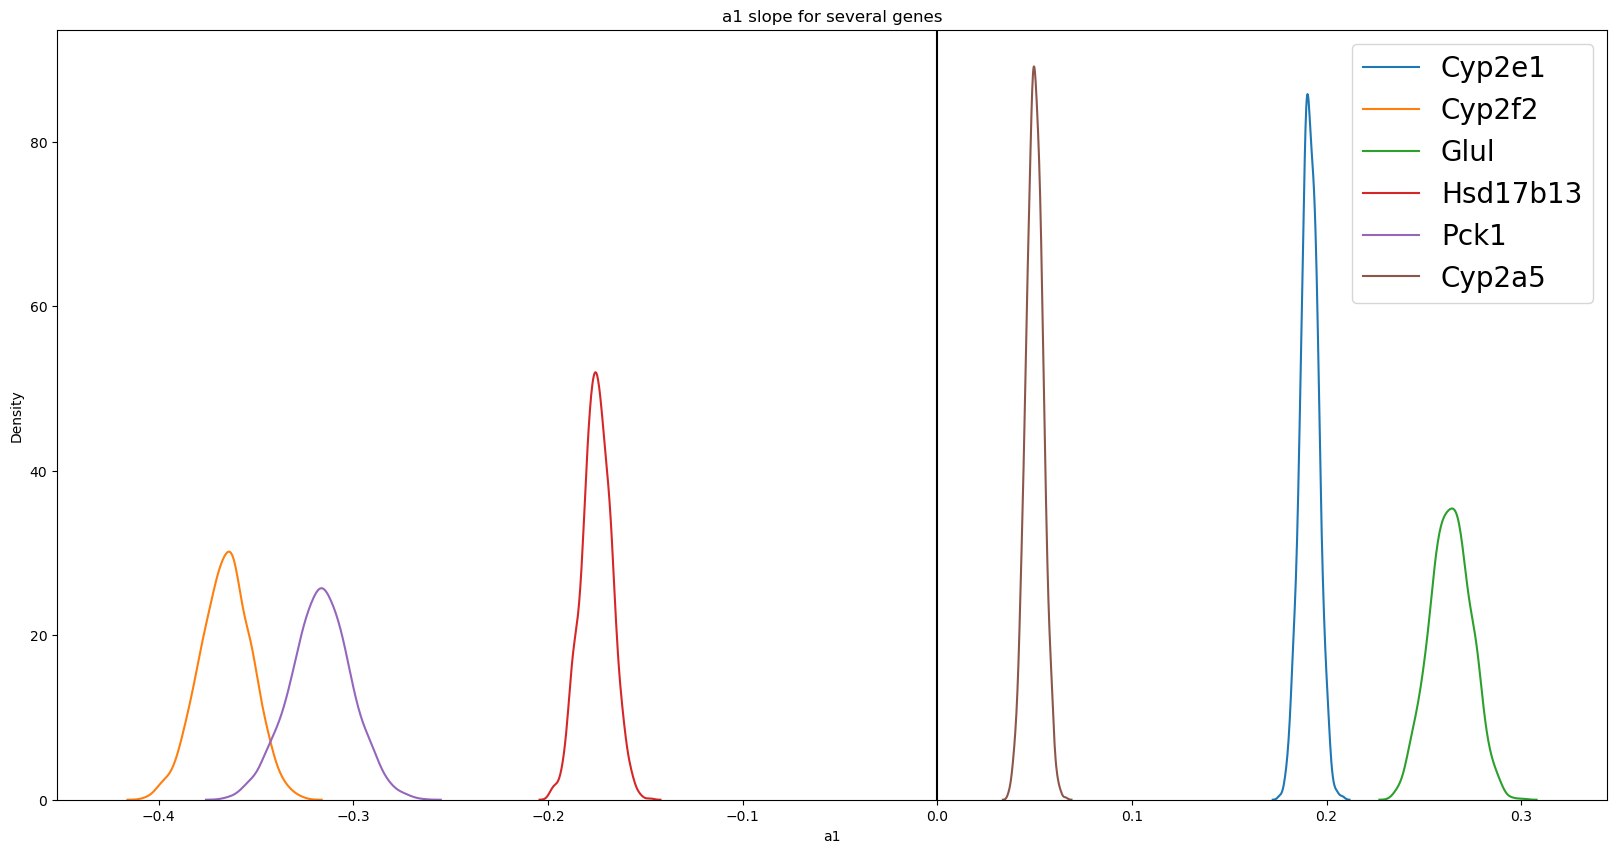

In [136]:
print(genes)

# plot distributions of a1 for gene Cyp2e1 (index  = 1), use a smoothed histogram with displot 
import seaborn as sns

gene_index(data_pyro, 'Cyp2e1')
plt.figure(figsize=(20, 10))

sns.kdeplot(samples["a1"].squeeze()[:, gene_index(data_pyro, 'Cyp2e1')],  label="Cyp2e1")
sns.kdeplot(samples["a1"].squeeze()[:, gene_index(data_pyro, 'Cyp2f2')],  label="Cyp2f2")
sns.kdeplot(samples["a1"].squeeze()[:, gene_index(data_pyro, 'Glul')],  label="Glul")
sns.kdeplot(samples["a1"].squeeze()[:, gene_index(data_pyro, 'Hsd17b13')],  label="Hsd17b13")
sns.kdeplot(samples["a1"].squeeze()[:, gene_index(data_pyro, 'Sds')],  label="Pck1")
sns.kdeplot(samples["a1"].squeeze()[:, gene_index(data_pyro, 'Cyp2a5')],  label="Cyp2a5")

# for g in genes:
#     sns.kdeplot(samples["a1"].squeeze()[:, gene_index(data_pyro, g)],  label=g)




# vertical line at x = 0
plt.axvline(0, color="black")
plt.xlabel("a1")

# add gene name on the plot itself rather than in the legend
# plt.text(0.1, 0.1, "Cyp2e1", transform=plt.gca().transAxes)

plt.title("a1 slope for several genes")
#bigger legend
plt.legend(fontsize=20)

# plt.figure(figsize=(20, 10))
# for i, g in enumerate(genes):
#     plt.subplot(5, 10, i + 1)
#     plt.hist(samples["a1"][:, i], bins=100, density=True)
#     plt.title(g)
#     plt.axvline(a1_pau[i], color="red")
#     plt.axvline(a1_pyro[i], color="green")
# samples['a1'].shape

/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

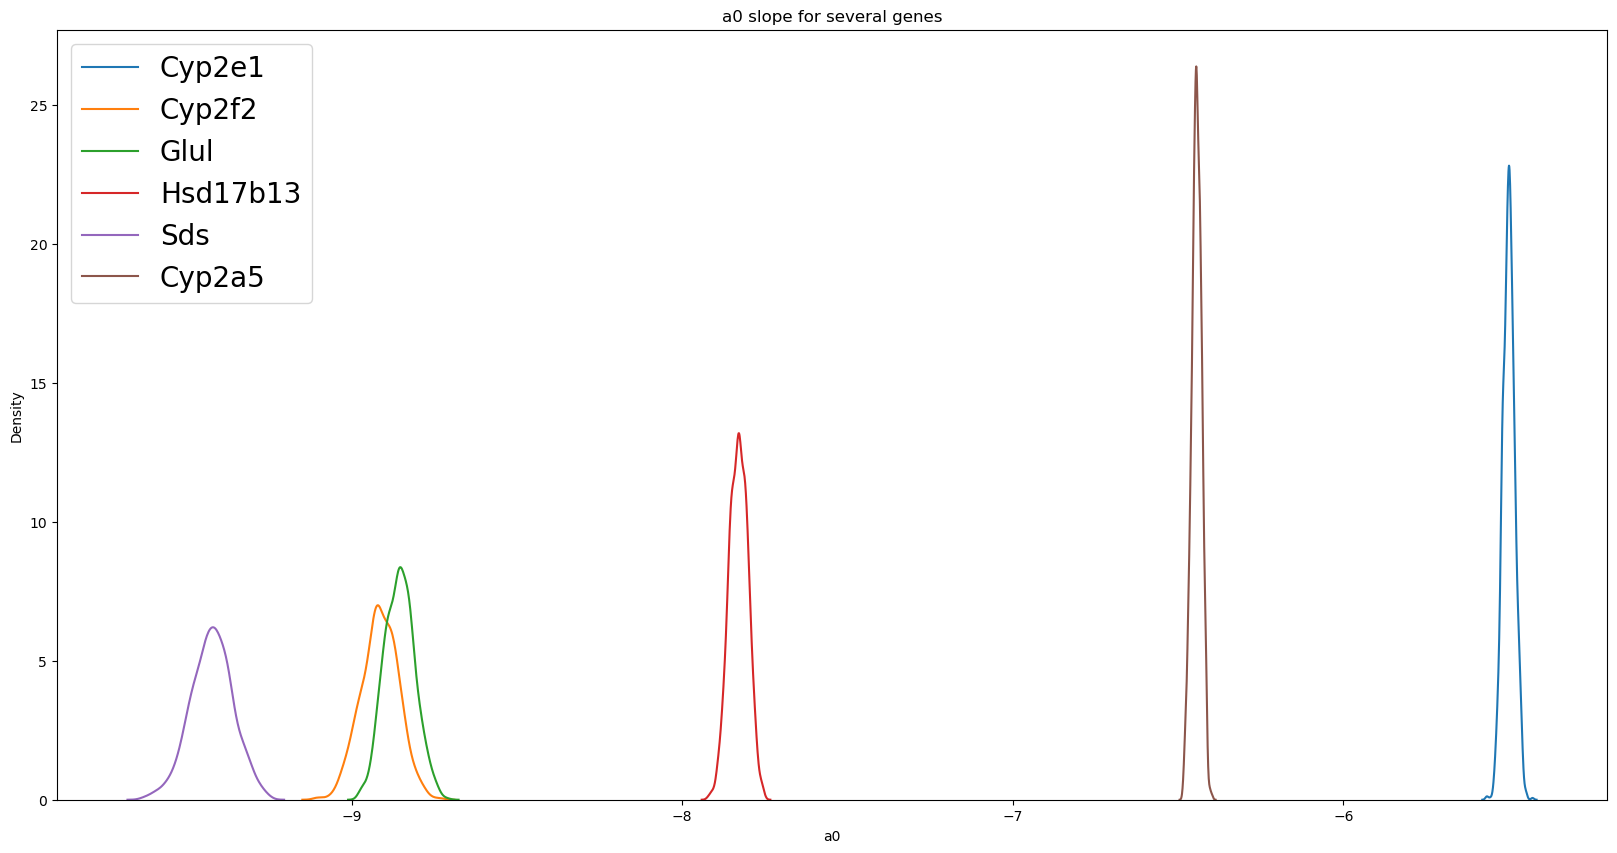

In [137]:
plt.figure(figsize=(20, 10))

sns.kdeplot(samples["a0"].squeeze()[:, gene_index(data_pyro, 'Cyp2e1')],  label="Cyp2e1")
sns.kdeplot(samples["a0"].squeeze()[:, gene_index(data_pyro, 'Cyp2f2')],  label="Cyp2f2")
sns.kdeplot(samples["a0"].squeeze()[:, gene_index(data_pyro, 'Glul')],  label="Glul")
sns.kdeplot(samples["a0"].squeeze()[:, gene_index(data_pyro, 'Hsd17b13')],  label="Hsd17b13")
sns.kdeplot(samples["a0"].squeeze()[:, gene_index(data_pyro, 'Sds')],  label="Sds")
sns.kdeplot(samples["a0"].squeeze()[:, gene_index(data_pyro, 'Cyp2a5')],  label="Cyp2a5")
# vertical line at x = 0

plt.xlabel("a0")

# add gene name on the plot itself rather than in the legend
# plt.text(0.1, 0.1, "Cyp2e1", transform=plt.gca().transAxes)

plt.title("a0 slope for several genes")
#bigger legend
plt.legend(fontsize=20)

In [120]:
samples["x"].squeeze().shape

(1500, 2000)

/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/salati/miniforge3/envs/numpyro/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

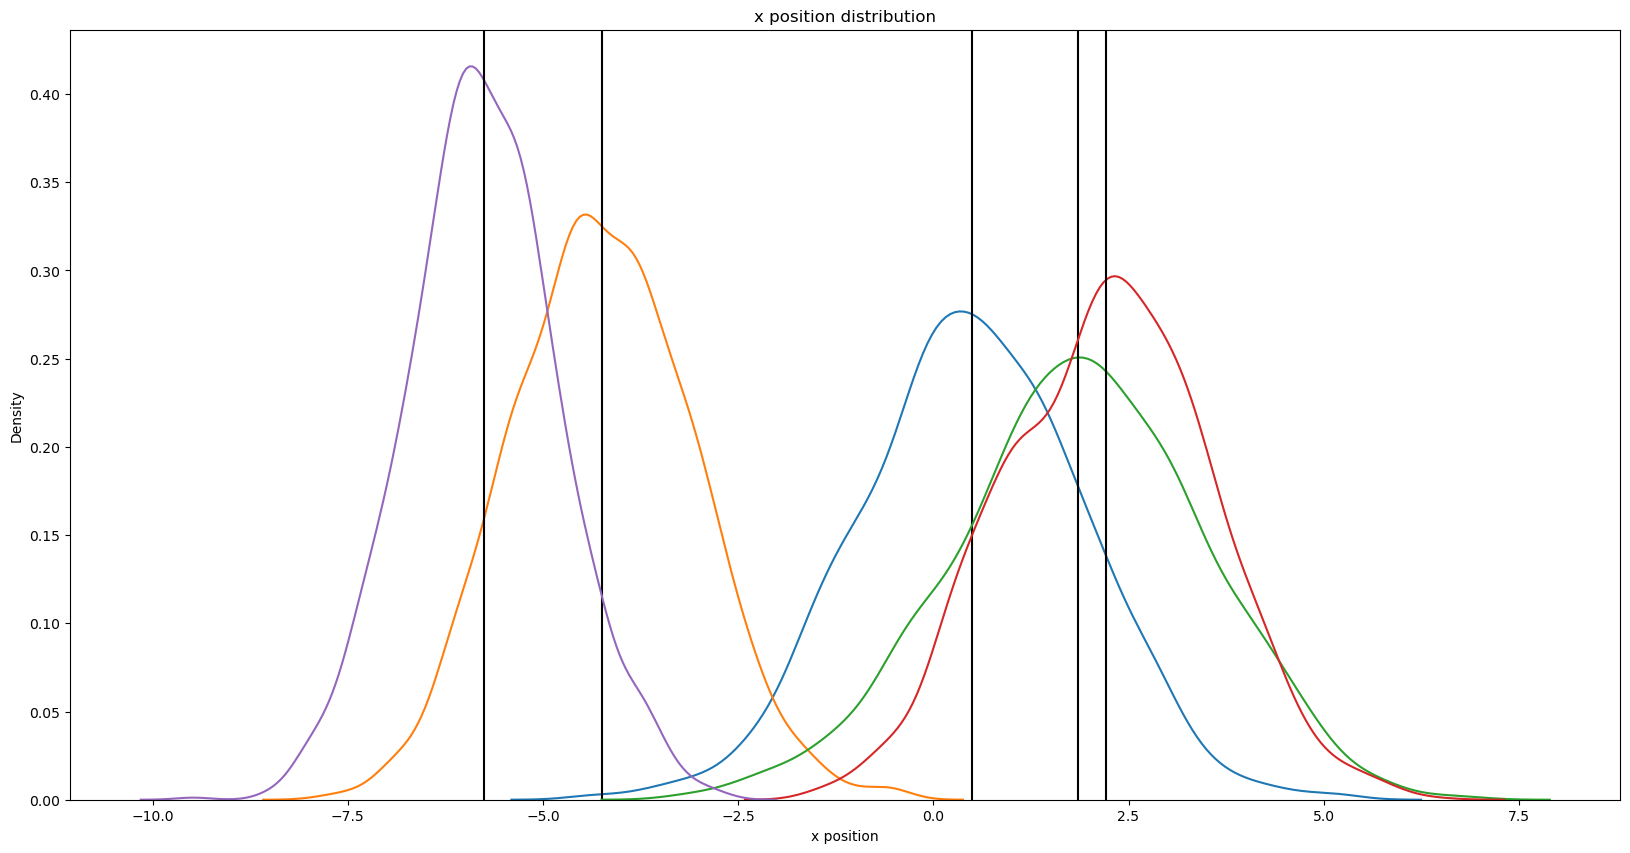

In [158]:
# now the same but with position x, I will take 10 random positions
# and than plot the distributions in the same style as above

plt.figure(figsize=(20, 10))
plt.title("x position distribution")
plt.xlabel("x position")
for i in range(5):
# for i in [2,3]:

    sns.kdeplot(samples["x"].squeeze()[:,i],  label="point")
    plt.axvline(x_pyro[i], color="black")

In [152]:
x_pyro[0:5]

Array([ 0.4890306, -4.239958 ,  1.8586583,  2.2168689, -5.759859 ],      dtype=float32)

In [154]:
# compute p value for population of samples['x'].squeeze()[:,0] and samples['x'].squeeze()[:,0]
# using the t-test
from scipy.stats import ttest_ind

print(x_pyro[2] , x_pyro[3])
print(samples["x"].squeeze()[:,2].mean())
# print the std
print(errors["x"][2], errors["x"][3])

ttest_ind(samples["x"].squeeze()[:,2], samples["x"].squeeze()[:,3])

1.8586583 2.2168689
1.8586583
1.6025966 1.3168107


TtestResult(statistic=-6.686336964558092, pvalue=2.7187009274131847e-11, df=2998.0)

In [157]:
ttest_ind([1,2,3] , [1,2,3])

ttest_ind([1,2,3] , [100,101,102])

TtestResult(statistic=-121.24974226776732, pvalue=2.7747958781457153e-08, df=4.0)

In [109]:
# # evaluates the likelihood
# def like_values(x, a0, a1, disp, log_UMI, DATA):
#     y = x[:, None] * a1[None, :] + log_UMI[:, None] + a0[None, :]
#     mu_cg_pyro = jnp.exp(y)
#     like_pyro = dist.GammaPoisson(concentration=1 / disp, rate=1 / (disp * mu_cg_pyro))
#     ll_cg_pyro = like_pyro.log_prob(DATA)
#     print(ll_cg_pyro.sum())
#     print(ll_cg_pyro.mean())
#     return ll_cg_pyro.sum(), ll_cg_pyro.mean()


# print("initial loss")
# like_0_sum, like_0_mean = like_values(X, A0, A1, disp, MP.log_n_UMI, DATA)
# print("final loss")
# like_final_sum, like_final_mean = like_values(
#     x_pyro, a0_pyro, a1_pyro, disp, MP.log_n_UMI, DATA
# )

0.11241583 0.005692736


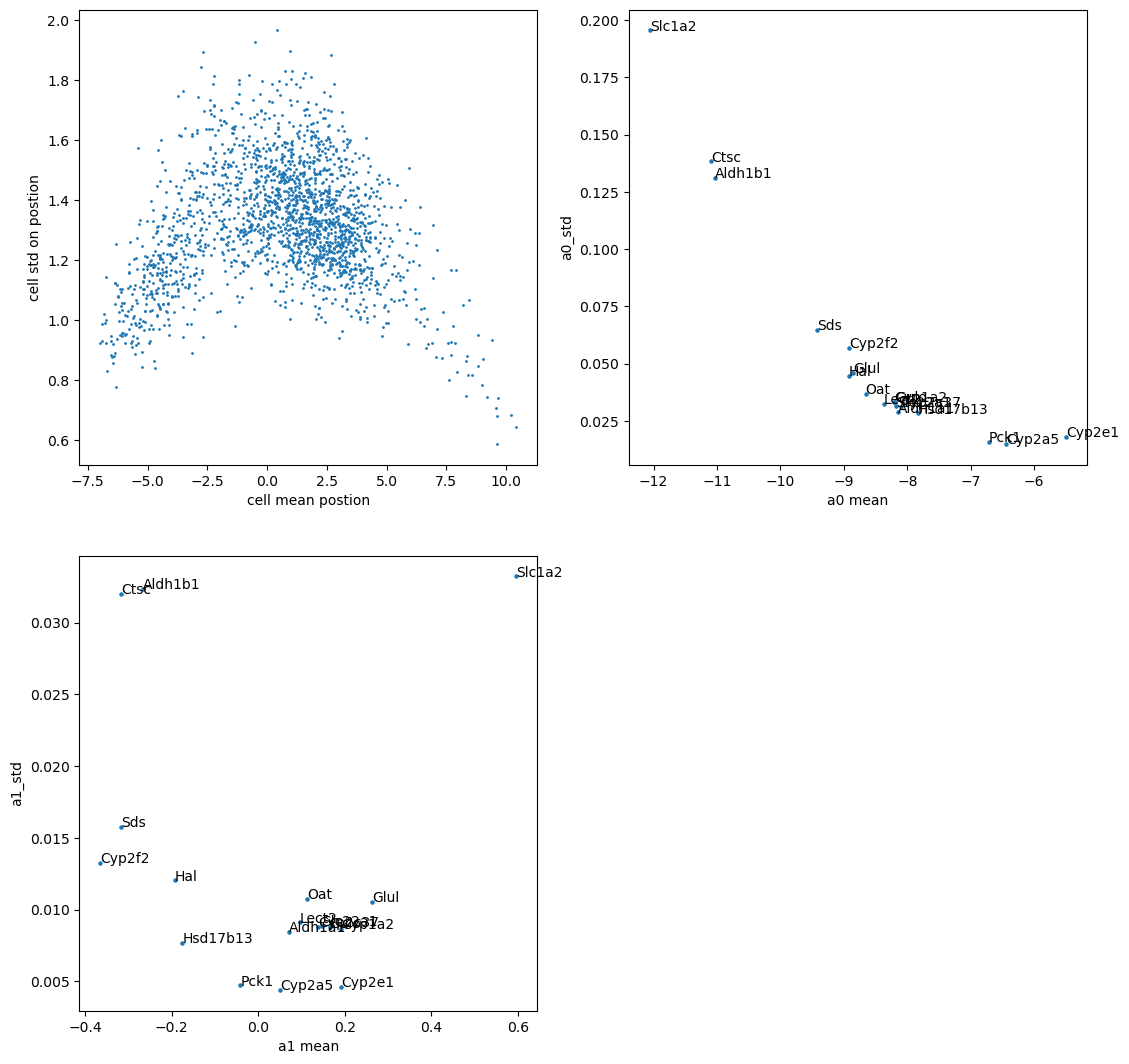

In [112]:
plt.figure(figsize=(13, 13))

plt.subplot(221)
plt.scatter(means["x"], errors["x"], s=1)
plt.xlabel("cell mean postion")
plt.ylabel("cell std on postion")

plt.subplot(222)
plt.scatter(means["a0"], errors["a0"], s=5)
for i, txt in enumerate(data_pyro.var.index):
    plt.annotate(txt, (means["a0"][i], errors["a0"][i]))
plt.xlabel("a0 mean")
plt.ylabel("a0_std")

plt.subplot(223)
plt.scatter(means["a1"], errors["a1"], s=5)
for i, txt in enumerate(data_pyro.var.index):
    plt.annotate(txt, (means["a1"][i], errors["a1"][i]))
plt.xlabel("a1 mean")
plt.ylabel("a1_std")

print(means["disp"], errors["disp"])

[0.20192854]


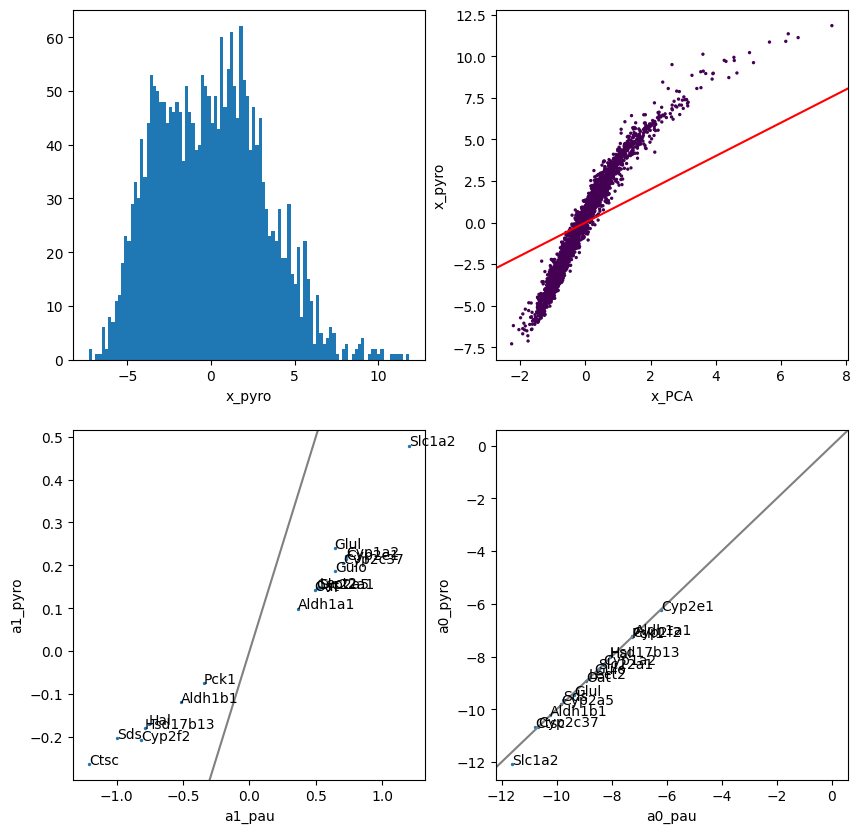

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.hist(x_pyro, bins=100)
plt.xlabel("x_pyro")

plt.subplot(222)
plt.scatter(x_unif, x_pyro, s=2, c=sample_id)
plt.xlabel("x_PCA")
plt.ylabel("x_pyro")
plt.axline((0, 0), slope=1, c="red")

plt.subplot(223)
plt.scatter(a1_pau, a1_pyro, s=2)
plt.xlabel("a1_pau")
plt.ylabel("a1_pyro")
plt.axline((0, 0), slope=1, color="gray")
for i, txt in enumerate(data_pyro.var.index):
    plt.annotate(data_pyro.var.index[i], (a1_pau[i], a1_pyro[i]))

plt.subplot(224)
plt.scatter(a0_pau, a0_pyro, s=2)
plt.xlabel("a0_pau")
plt.ylabel("a0_pyro")
plt.axline((0, 0), slope=1, color="gray")
for i, txt in enumerate(data_pyro.var.index):
    plt.annotate(data_pyro.var.index[i], (a0_pau[i], a0_pyro[i]))


print(disp)

In [ ]:
# df_a0 = pd.DataFrame(a0_pyro,index=sample_list ,columns=data_pyro.var.index)
# df_a1 = pd.Series(a1_pyro, index=data_pyro.var.index)
# df_x  = pd.Series(x_pyro, index=data_pyro.obs.index)

# # Write the DataFrame to a .txt file
# df_a0.to_csv("coeff_values/fit_a_hild_genes_a0.txt", sep="\t")
# df_a1.to_csv("coeff_values/fit_a_hild_genes_a1.txt", sep="\t")
# df_x.to_csv("coeff_values/fit_a_hild_genes_x.txt",   sep="\t")

# plots

## shifts

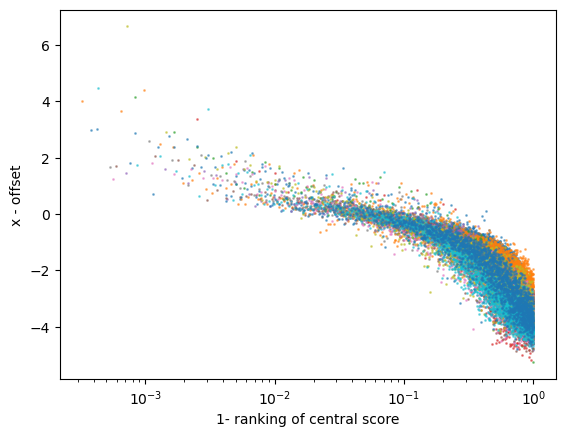

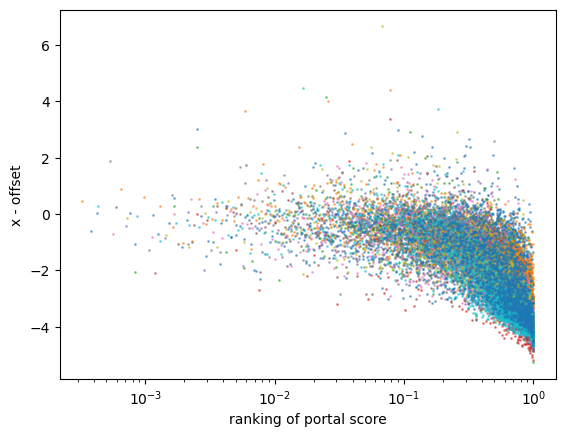

In [ ]:
xs = []
# central2=['Glul', 'Slc1a2']
for s in np.unique(sample_id):
    # print(s)
    idx = sample_id == s
    central_score = data[idx, central].layers["f_cg"].sum(1)
    x = x_pyro[idx]
    rc = central_score.argsort().argsort() / idx.sum()
    offset = x[np.logical_and(rc > 0.9, rc < 0.99)].median()
    col = np.logical_and(rc > 0.9, rc < 0.99)
    xs.append(offset)
    plt.scatter(1 - rc, x - offset, s=1, alpha=0.5)
    plt.xlabel("1- ranking of central score")
    plt.ylabel("x - offset")
    plt.xscale("log")
plt.show()
xs

for s in np.unique(sample_id):
    idx = sample_id == s
    portal_score = data[idx, portal].layers["f_cg"].sum(1)
    x = x_pyro[idx]
    rp = portal_score.argsort().argsort() / idx.sum()
    # offset=x[np.logical_and(r>0.9, r<0.99)].median()
    # xs.append(offset)
    plt.scatter(rp, x - xs[s], s=1, alpha=0.5)
    plt.xscale("log")
    plt.xlabel("ranking of portal score")
    plt.ylabel("x - offset")

In [ ]:
# # plt.figure(figsize=(10,5))
# for s in np.unique(sample_id):
#     x=x_pyro[sample_id==s]
#     x=x-xs[s]+2
#     plt.hist(x, bins=100, alpha=0.5, label=s)
#     plt.xlim((-5,5))
#     plt.xlabel('x_pyro')
#     plt.title(' '.join(sample_annot[s,3:]))
#     plt.show()
# plt.legend()

In [ ]:
# change=12
# mask_mt=data.obs['percent.mt']<change
# mask_mt2=data.obs['percent.mt']>change

# cor1=np.corrcoef(x_pyro[mask_mt],data[mask_mt,:].obs['percent.mt'])[0,1]
# cor2=np.corrcoef(x_pyro[mask_mt2],data[mask_mt2].obs['percent.mt'])[0,1]

# plt.figure(figsize=(20,10))
# plt.subplot(121)
# plt.scatter(x_pyro[mask_mt],data[mask_mt,:].obs['percent.mt'],s=1,label=cor1)
# plt.xlabel('x_pyro')
# plt.ylabel('perc_mito')
# plt.title('less than {}% mito'.format(change) )
# plt.legend()


# plt.subplot(122)
# plt.scatter(x_pyro[mask_mt2],data[mask_mt2,:].obs['percent.mt'],s=1, label=cor2)
# plt.xlabel('x_pyro')
# plt.ylabel('perc_mito')
# plt.title('more than {}% mito'.format(change) )
# plt.legend()